# **Using PyTorch to build a neural net with Autodifferentiation**


In [ ]:
import torch 
import torch.nn as nn
#importing required libraries
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Genrating Data using PyTorch datastructure

In [ ]:
#number of samples to generate
n = 200

#input and output dimensions
in_dims = 3

out_dims = 2

#generating uniform random data using pytorch
x = torch.rand(n, in_dims).uniform_(-1, 1)

weights_true = np.array([[5, -1, -2], [-1,-1,3],]).T
bias_true = np.array([[1, 1]])
print(x.shape, weights_true.shape, bias_true.shape)

y_true = (5 * x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

torch.Size([200, 3]) (3, 2) (1, 2)
x: torch.Size([200, 3]), weights: (3, 2), bias: (1, 2), y: torch.Size([200, 2])


# 3D Plot to Visualize data

In [ ]:
def plot_3d(x, y, y_pred=None):
  X_reduced = TSNE(n_components=2).fit_transform(x)
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_reduced[:, 0], X_reduced[:, 1], y, label='True')
  if y_pred is not None:
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], y_pred, marker='v', label='Predicted')
  plt.legend()
  plt.show()

# Activation Function

In [ ]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = torch.clamp(self.input_, min=0, out=None)
    return self.output
  
  def backward(self, output_gradient):
    self.input_gradient = (self.input_ > 0) * output_gradient
    return self.input_gradient

# Calculating Mean Squared Error

In [ ]:
class MSE:
  def __call__(self, y_true, y_pred):
    self.y_pred = y_pred
    self.y_true = y_true
    return torch.mean((y_true - y_pred) ** 2)
    
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

# Defining the Linear Layer 

In [ ]:
class Linear:
  def __init__(self, in_dims: int, hidden: int = 1):
    self.weights = torch.rand(in_dims, hidden)
    self.bias = torch.zeros(hidden,)
  
  def __call__(self,x):
    self.x = x
    output = torch.mm(x, self.weights + self.bias)
    return output
  
  def backward(self, gradient):
    self.weights_gradient = torch.mm(torch.transpose(self.x,0,1), gradient)
    self.bias_gradient = gradient.sum(0)
    self.x_gradient = torch.mm(gradient, torch.transpose(self.weights,0,1))
    return self.x_gradient
  
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

# Model using Acivation Function and Linear Layers

In [ ]:
class Model:
  def __init__(self, input_dim, hidden_layers):
    self.linear1 = Linear(input_dim, hidden_layers)
    self.relu = Relu()
    self.linear2 = Linear(hidden_layers, 10)
    self.relu = Relu()
    self.linear3 = Linear(10, 2)

  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu(l1)
    l2 = self.linear2(r1)
    r2 = self.relu(l2)
    l3 = self.linear3(r2)
    return l3

  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu_gradient1 = self.relu.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu_gradient1)
    relu_gradient2 = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient2)
    return linear1_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

# Training Loop

In [ ]:
from typing import Callable

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

# Converting data to tensor using Torch

In [ ]:
loss = MSE()
model = Model(in_dims,10)
x_tensor = torch.tensor(x).clone().detach().float()
y_true_tensor = torch.tensor(y_true).clone().detach().float() 
y_pred_tensor = model(x_tensor)
loss_value=loss(y_pred_tensor,y_true_tensor)
print(loss_value)

tensor(69.0775, grad_fn=<MeanBackward0>)


<ipython-input-86-e74c40fa0fae>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x).clone().detach().float()
<ipython-input-86-e74c40fa0fae>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true_tensor = torch.tensor(y_true).clone().detach().float()


# Fitting the model after training

In [ ]:
torch_fit(x_tensor,y_true_tensor,loss=loss,model=model,lr=0.1,num_epochs=100)

tensor(69.7993, grad_fn=<MeanBackward0>)
tensor(64.8567, grad_fn=<MeanBackward0>)
tensor(60.9976, grad_fn=<MeanBackward0>)
tensor(56.3566, grad_fn=<MeanBackward0>)
tensor(51.2266, grad_fn=<MeanBackward0>)
tensor(49.0790, grad_fn=<MeanBackward0>)
tensor(47.6195, grad_fn=<MeanBackward0>)
tensor(45.7598, grad_fn=<MeanBackward0>)
tensor(43.3934, grad_fn=<MeanBackward0>)
tensor(40.6078, grad_fn=<MeanBackward0>)
tensor(39.5995, grad_fn=<MeanBackward0>)
tensor(43.9730, grad_fn=<MeanBackward0>)
tensor(60.9717, grad_fn=<MeanBackward0>)
tensor(57.5679, grad_fn=<MeanBackward0>)
tensor(55.0828, grad_fn=<MeanBackward0>)
tensor(53.2141, grad_fn=<MeanBackward0>)
tensor(51.8107, grad_fn=<MeanBackward0>)
tensor(50.5342, grad_fn=<MeanBackward0>)
tensor(49.2067, grad_fn=<MeanBackward0>)
tensor(47.3516, grad_fn=<MeanBackward0>)
tensor(44.3989, grad_fn=<MeanBackward0>)
tensor(40.2481, grad_fn=<MeanBackward0>)
tensor(35.8868, grad_fn=<MeanBackward0>)
tensor(31.2330, grad_fn=<MeanBackward0>)
tensor(27.9503, 

# Plotting data post training

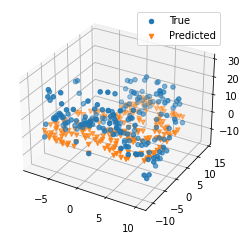

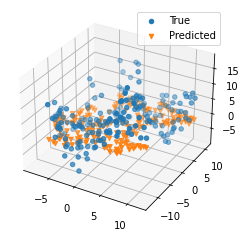

In [ ]:
plot_3d(x_tensor, y_true_tensor[:,0], model(x_tensor).detach()[:,0])
plot_3d(x_tensor, y_true_tensor[:,1], model(x_tensor).detach()[:,1])